# **Imports**

# Importing Libraries

In [13]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os
import cv2 as cv
from tensorflow import keras
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

In [14]:
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import Concatenate
from keras.layers import MaxPooling2D
from keras.layers import Conv2DTranspose
from keras.metrics import MeanIoU

from keras import Model

# **Data**

In [15]:
images = []
mask = []

image_path = '../input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/'
mask_path = '../input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks/'

image_names = sorted(next(os.walk(image_path))[-1])
mask_names = sorted(next(os.walk(mask_path))[-1])

if image_names == mask_names:
    print('Image and Mask are corretly Placed!!')


Image and Mask are corretly Placed!!


In [16]:
SIZE = 128
images = np.zeros(shape=(len(image_names),SIZE, SIZE, 3))
masks = np.zeros(shape=(len(image_names),SIZE, SIZE, 1))

for id in tqdm(range(len(image_names)), desc="Images"):
    path = image_path + image_names[id]
    img = img_to_array(load_img(path)).astype('float')/255.
    img = cv.resize(img, (SIZE,SIZE), cv.INTER_AREA)
    images[id] = img

for id in tqdm(range(len(mask_names)), desc="Mask"):
    path = mask_path + mask_names[id]
    mask = img_to_array(load_img(path)).astype('float')/255.
    mask = cv.resize(mask, (SIZE,SIZE), cv.INTER_AREA)
    masks[id] = mask[:,:,:1]

Mask: 100%|██████████| 2841/2841 [00:41<00:00, 68.32it/s] 


# Create datasets for model training and validation

In [17]:
X = images
y = masks

In [18]:
print(X.shape)
print(y.shape)

(2841, 128, 128, 3)
(2841, 128, 128, 1)


In [19]:
print(X.max())
print(X.min())

0.9449622060738357
0.0


In [20]:
print(y.max())
print(y.min())

1.0
0.0


# Visualization

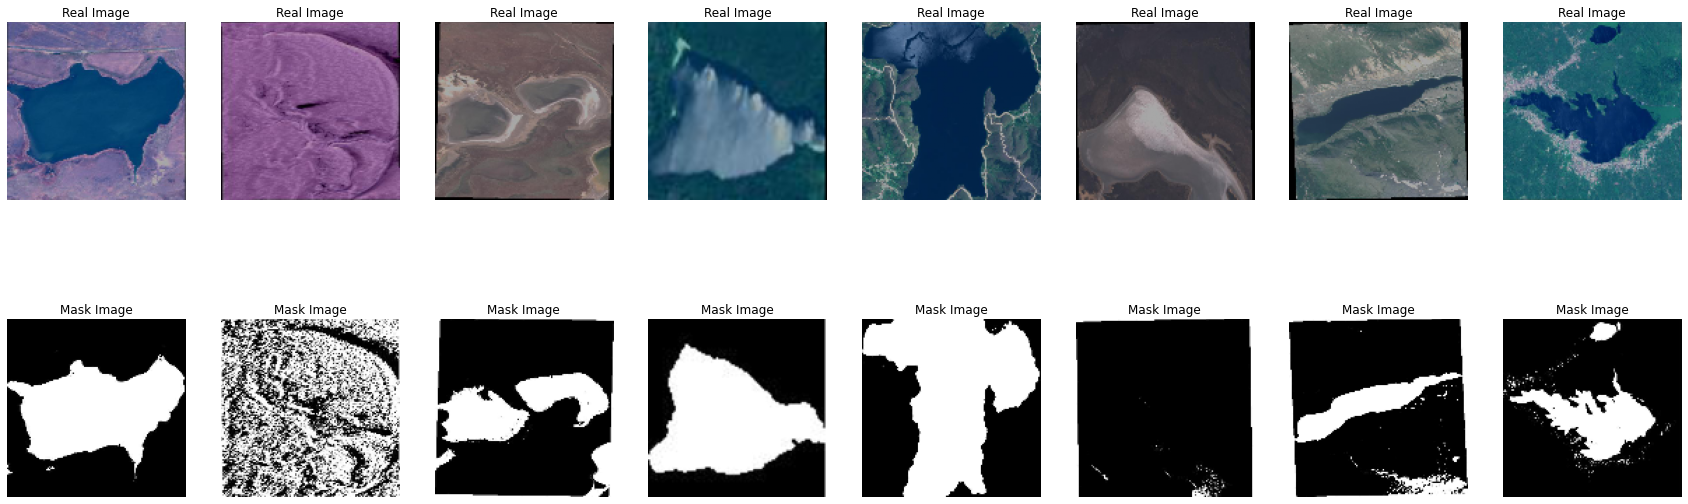

In [21]:
plt.figure(figsize = (30,10))
i = 0
while i < 8 :
    
    x = np.random.randint(0,780)
    
    plt.subplot(2,8,i+1)
    plt.imshow(X[x],'gray')
    plt.title('Real Image')
    plt.axis('off')
    
    plt.subplot(2,8,i+9)
    plt.imshow(y[x],'gray')
    plt.title('Mask Image')
    plt.axis('off')
    
    i += 1
plt.show()

# Train test split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [23]:
print(X_train.shape)
print(y_train.shape)

(2556, 128, 128, 3)
(2556, 128, 128, 1)


In [24]:
print(X_test.shape)
print(y_test.shape)

(285, 128, 128, 3)
(285, 128, 128, 1)


# Model Creation [U-net](https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5)
<img src = "https://miro.medium.com/max/3600/1*f7YOaE4TWubwaFF7Z1fzNw.png"/>

### Basic Architecture
<div style = "text-align: justify">U-net architecture can localize the area of interest. It was first used in Biomedical imaging. The reason it is able to <b>distinguish and localize</b> the area is by classifying every pixel in the input image. <b>So the size of input and output images is the same</b>. It comprises of two paths - <b>Contracting path and Expanding path</b>.</div>

### Contract Path
The Contracting path has two Convolutional layers and a Maxpooling layer.

### Expansive Path
<div style = "text-align: justify">The Expanding path consists of both transpose Convolutional layer and two Convolutional layers. The corresponding image from contracting path is fed to this layer for precise predictions.</div>

# **U-Net**

### Contracting path

In [25]:
inply = Input((128, 128, 3,))

conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(inply)
conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv1)
pool1 = MaxPooling2D((2,2), strides = 2, padding = 'same',)(conv1)
drop1 = Dropout(0.2)(pool1)

conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(drop1)
conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv2)
pool2 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv2)
drop2 = Dropout(0.2)(pool2)

conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(drop2)
conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv3)
pool3 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv3)
drop3 = Dropout(0.2)(pool3)

conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(drop3)
conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv4)
pool4 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv4)
drop4 = Dropout(0.2)(pool4)

2022-11-27 08:05:48.510043: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 08:05:48.596980: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 08:05:48.597800: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 08:05:48.599590: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

### Bottleneck layer

In [26]:
convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(drop4)
convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(convm)

### Expanding layer

In [27]:
tran5 = Conv2DTranspose(2**9, (2,2), strides = 2, padding = 'valid', activation = 'relu')(convm)
conc5 = Concatenate()([tran5, conv4])
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conc5)
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv5)
drop5 = Dropout(0.1)(conv5)

tran6 = Conv2DTranspose(2**8, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop5)
conc6 = Concatenate()([tran6, conv3])
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conc6)
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv6)
drop6 = Dropout(0.1)(conv6)

tran7 = Conv2DTranspose(2**7, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop6)
conc7 = Concatenate()([tran7, conv2])
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conc7)
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv7)
drop7 = Dropout(0.1)(conv7)

tran8 = Conv2DTranspose(2**6, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop7)
conc8 = Concatenate()([tran8, conv1])
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conc8)
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv8)
drop8 = Dropout(0.1)(conv8)

In [28]:
outly = Conv2D(2**0, (1,1), activation = 'sigmoid', padding = 'same')(drop8)
model = Model(inputs = inply, outputs = outly, name = 'U-net')

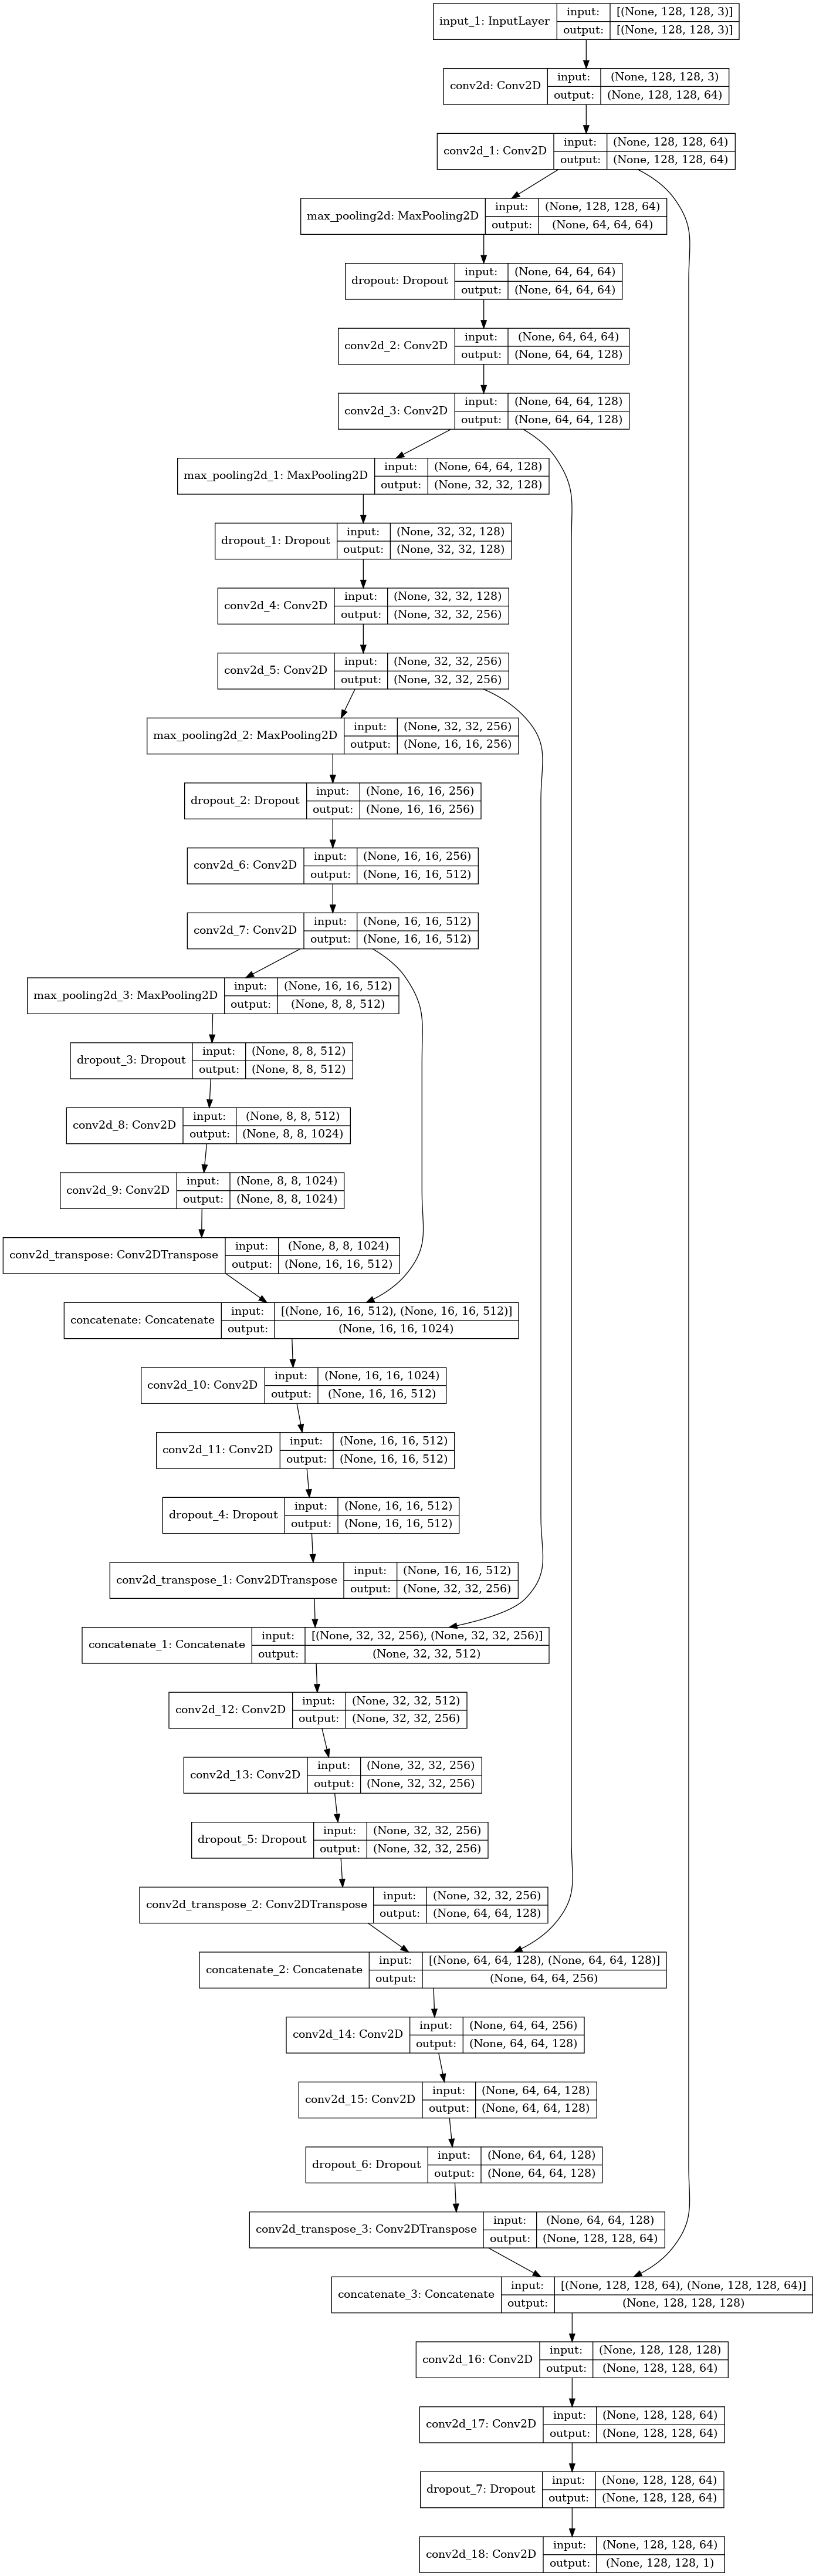

In [29]:
keras.utils.plot_model(model, './model_plot.png', show_shapes = True)

# Loss function

<div style = "text-align: justify">The loss for evaluating the performance of model in semantic segmentation will be <b>IoU (Intersection over Union)</b>. It is the ratio of intersection of pixels between predicted and target image over their union. The MeanIoU() method in tf.keras.metrics package can be used.</div>

In [30]:
model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam(learning_rate = 0.00005),metrics=['accuracy', MeanIoU(num_classes=2, name='IoU')])
# print(model.summary())

# Training

In [31]:
history = model.fit(X_train, y_train, epochs = 50, batch_size = 16, validation_data = (X_test, y_test))

2022-11-27 08:05:53.085675: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 502530048 exceeds 10% of free system memory.
2022-11-27 08:05:54.035564: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 502530048 exceeds 10% of free system memory.
2022-11-27 08:05:54.606918: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-11-27 08:05:57.223818: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


160/160 [==============================] - 32s 137ms/step - loss: 0.1911 - accuracy: 0.5669 - IoU: 0.3814 - val_loss: 0.1522 - val_accuracy: 0.6466 - val_IoU: 0.3879
Epoch 2/50
160/160 [==============================] - 18s 114ms/step - loss: 0.1371 - accuracy: 0.6608 - IoU: 0.3814 - val_loss: 0.1208 - val_accuracy: 0.6827 - val_IoU: 0.3879
Epoch 3/50
160/160 [==============================] - 18s 114ms/step - loss: 0.1165 - accuracy: 0.6839 - IoU: 0.4121 - val_loss: 0.1004 - val_accuracy: 0.7050 - val_IoU: 0.4212
Epoch 4/50
160/160 [==============================] - 18s 114ms/step - loss: 0.1047 - accuracy: 0.6997 - IoU: 0.4581 - val_loss: 0.1048 - val_accuracy: 0.7021 - val_IoU: 0.4383
Epoch 5/50
160/160 [==============================] - 18s 114ms/step - loss: 0.0990 - accuracy: 0.7046 - IoU: 0.4690 - val_loss: 0.1011 - val_accuracy: 0.7031 - val_IoU: 0.4394
Epoch 6/50
160/160 [==============================] - 18s 114ms/step - loss: 0.0931 - accuracy: 0.7112 - IoU: 0.4712 - val_los

# Model Performance

Text(0.5, 1.0, 'IoU vs Epochs')

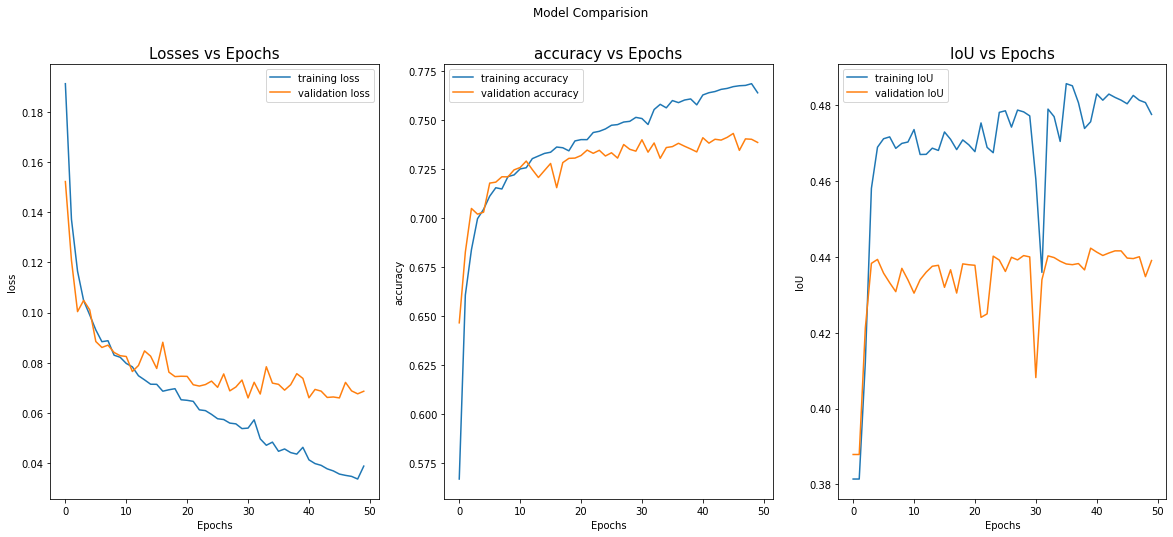

In [32]:
train_loss, train_acc, train_IoU, valid_loss, valid_acc, valid_IoU = history.history.values()
plt.figure(figsize=(20,8))
plt.suptitle("Model Comparision")

plt.subplot(1,3,1)
plt.plot(train_loss)
plt.plot(valid_loss)
plt.legend(['training loss', 'validation loss'])
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Losses vs Epochs', fontsize = 15)

plt.subplot(1,3,2)
plt.plot(train_acc)
plt.plot(valid_acc)
plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('accuracy vs Epochs', fontsize = 15)

plt.subplot(1,3,3)
plt.plot(train_IoU)
plt.plot(valid_IoU)
plt.legend(['training IoU', 'validation IoU'])
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.title('IoU vs Epochs', fontsize = 15)

# Model Prediction for testing

In [33]:
y_pred = model.predict(X_test)

In [34]:
print(y_pred.shape)

(285, 128, 128, 1)


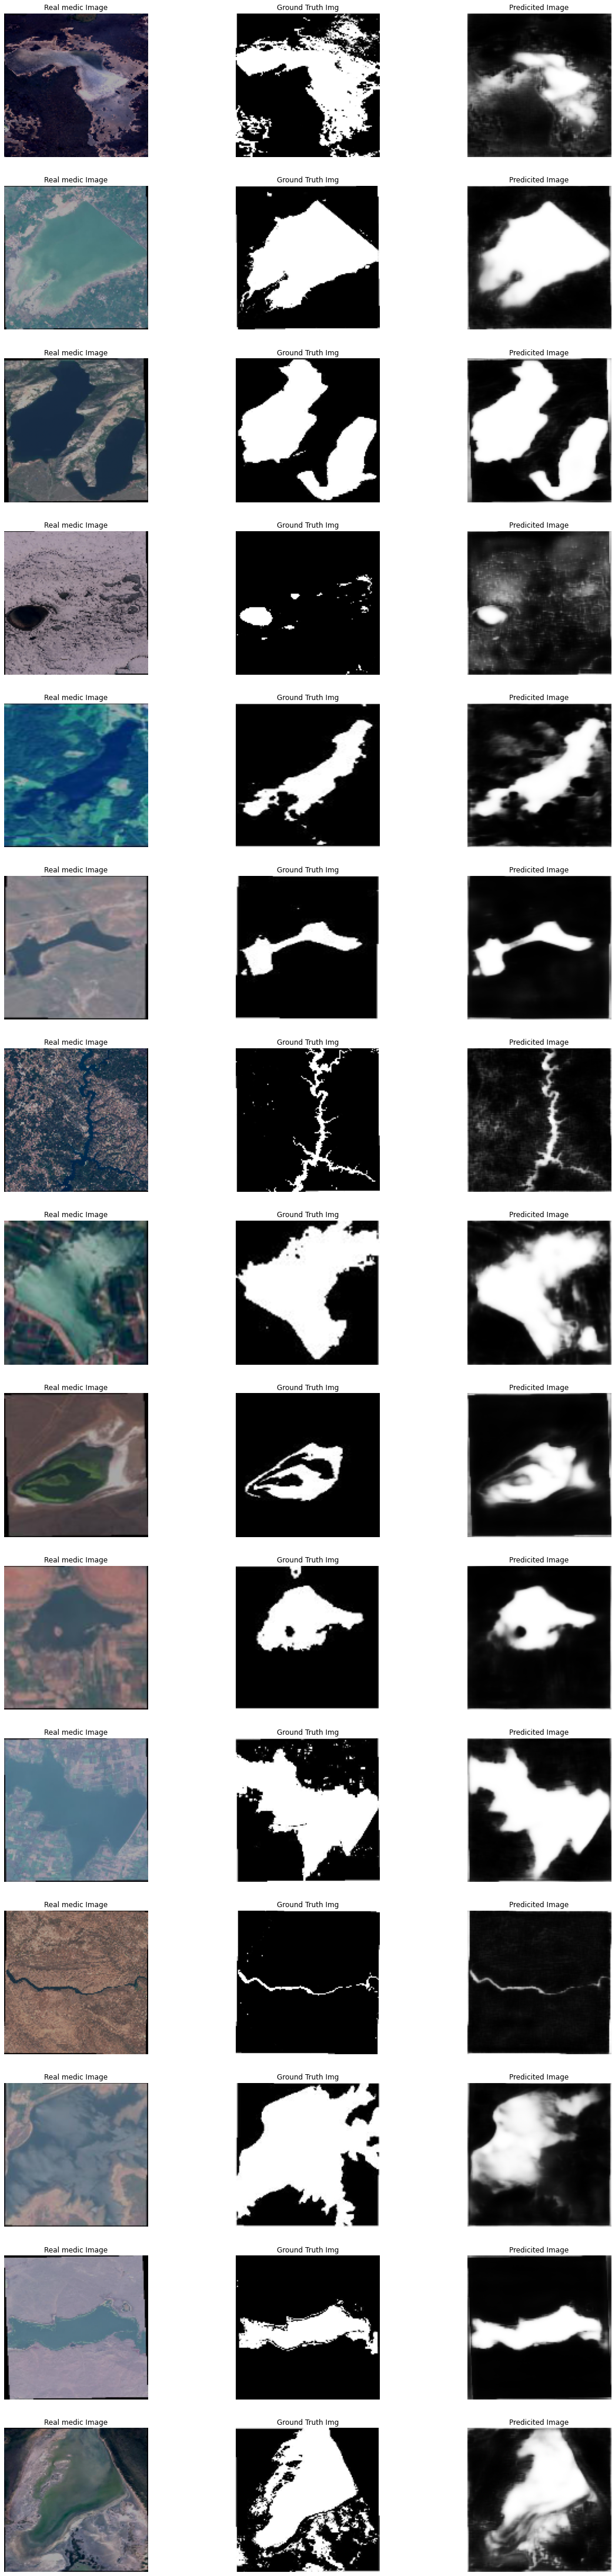

In [35]:
plt.figure(figsize = (20,80))

i = 0
x = 0
while i < 45 :
    
    plt.subplot(15,3,i+1)
    plt.imshow(X_test[x])
    plt.title('Real medic Image')
    plt.axis('off')
    
    plt.subplot(15,3,i+2)
    plt.imshow(y_test[x], 'gray')
    plt.title('Ground Truth Img')
    plt.axis('off')
    
    plt.subplot(15,3,i+3)
    plt.imshow(y_pred[x], 'gray')
    plt.title('Predicited Image')
    plt.axis('off')
    
    x += 1
    i += 3
plt.show()